<center>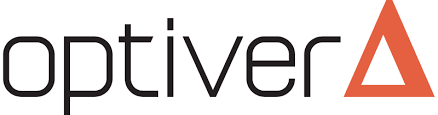</center>


## <center>Optiver Realized Volatility Prediction</center>
### <center>📈Apply your data science skills to make financial markets better📉</center>

## Table of contents <a id='0.1'></a>
1. [Introduction](#1)
2. [Import Packages](#2)
3. [Utility](#3)
4. [Data Overview](#4)
    * [Book Order Data](#4.1)
    * [Trade Execution Data](#4.2)
    * [Train](#4.3)
    * [Test](#4.4)
    * [Submission](#4.5)
5. [Individual Feature Distribution](#5)
    * [Continuous Feature Distribution](#5.1)
    * [Categorical Feature Distribution](#5.2)
6. [Weighted Average Price](#6)
    * [Naive prediction: Stock ID 7](#6.1)

# 1. <a id='1'>Introduction</a>
[Table of contents](#0.1)

This competiton is hosted by [Optiver](https://www.optiver.com/) a leading trading firm. Optiver is a proprietary trading firm with nine locations across Europe, Asia-Pacific and North America. **The goal in this compeition is to predict the short-term volatility for stocks. We need to design a model which can forcast volatility over 10 minutes period** to create better access and prices for [options](#0.2). We are dealing time-series data. 

## About Competition Host

Optiver, one of the world’s largest electronic market makers. Optiver is dedicated to continuously improving financial markets, creating better access and prices for options, ETFs, cash equities, bonds and foreign currencies on numerous exchanges around the world.

In [ ]:
from IPython.display import HTML

HTML('<center><iframe width="1000" height="450" src="https://www.youtube.com/embed/sK-HqhT6nA0" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>')

## What is Market Maker ?

[Table of contents](#0.1)

A market maker (MM) is a firm or individual who actively quotes two-sided markets(A two-sided market exists when both buyers and sellers meet to exchange a product or service) in a security, providing bids and offers (known as asks) along with the market size of each.

[source](https://www.investopedia.com/terms/m/marketmaker.asp#)

## What is Volatility ?

[Table of contents](#0.1)

In most simple term **Volatility is associated with the amount of risk or uncertainty concerning how the stock markets will move.**

Volatility is typically measured using either **standard deviation** or **variance**. In either case, the higher the value, the more volatile are the prices or the returns.  It means that a high standard deviation value suggests that prices are spread across a wide spectrum. Conversely, a low standard deviation value indicates that prices are closely knit across a narrow range.

[source](https://groww.in/p/volatility/)

In [ ]:
HTML('<center><iframe width="1000" height="450" src="https://www.youtube.com/embed/3_jjS3x3oC0" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>')

## What is Option ? <a id='0.2'></a>

[Table of contents](#0.1)

An option is a contract that is written by a seller that conveys to the buyer the right — but not an obligation to buy (for a call option) or to sell (for a put option) a particular asset, at a specific price (strike price/exercise price) in future.

In return for granting the option, the seller collects a payment (known as a premium) from the buyer.

[source](https://groww.in/p/option-trading/)

## About Competition Data

[Table of contents](#0.1)

The data includes **order book snapshots and executed trades.**

We are provided with the following files:
   * book_train.parquet/book_test.parquet - This provides most competitive **buy** and **sell** data entered in the market. These parquet files consists of following columns - 
   
      * stock_id - ID code for the stock. Not all stock IDs exist in every time bucket. Parquet coerces this column to the       * categorical data type when loaded; you may wish to convert it to int8.
      * time_id - ID code for the time bucket. Time IDs are not necessarily sequential but are consistent across all stocks.
      * seconds_in_bucket - Number of seconds from the start of the bucket, always starting from 0.
      * bid_price[1/2] - Normalized prices of the most/second most competitive buy level.
      * ask_price[1/2] - Normalized prices of the most/second most competitive sell level.
      * bid_size[1/2] - The number of shares on the most/second most competitive buy level.
      * ask_size[1/2] - The number of shares on the most/second most competitive sell level.
      
      
   * trade_train.parquet/trade_test.parquet - This file is more sparse than the order book since it contains data on trade that actually executed. Usually, in the market, there are more passive buy/sell intention updates (book updates) than actual trades. These files have following columns - 
   
      * stock_id - Same as above.
      * time_id - Same as above.
      * seconds_in_bucket - Same as above. Note that since trade and book data are taken from the same time window and trade data is more sparse in general, this field is not necessarily starting from 0.
      * price - The average price of executed transactions happening in one second. Prices have been normalized and the average has been weighted by the number of shares traded in each transaction.
      * size - The sum number of shares traded.
      * order_count - The number of unique trade orders taking place.
      
  * train.csv The ground truth values for the training set.

     * stock_id - Same as above, but since this is a csv the column will load as an integer instead of categorical.
     * time_id - Same as above.
     * target - The realized volatility computed over the 10 minute window following the feature data under the same stock/time_id. There is no overlap between feature and target data. You can find more info in our tutorial notebook.
     
   * test.csv Provides the mapping between the other data files and the submission file. As with other test files, most of the data is only available to your notebook upon submission with just the first few rows available for download.

    * stock_id - Same as above.
    * time_id - Same as above.
    * row_id - Unique identifier for the submission row. There is one row for each existing time ID/stock ID pair. Each time window is not necessarily containing every individual stock.
    
* sample_submission.csv - A sample submission file in the correct format.

   * row_id - Same as in test.csv.
   * target - Same definition as in train.csv. The benchmark is using the median target value from train.csv.
   
## Competition Goal

We need to generate series of short term-signals to predict the realized volatality of the next 10-minute window for stocks using the book and trade data of a fixed 10-minute window.

# 2. <a id='2'>Import Packages</a>
[Tabale of contents](#0.1)

In [ ]:
# basic 
import glob
import os, gc
import warnings
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [ ]:
# directory
print('Competition Data/Files')
ROOT = '../input/optiver-realized-volatility-prediction/'
os.listdir(ROOT)

# 3. <a id='3'>Utility</a>
[Tabale of contents](#0.1)

In [ ]:
# Weighted Average Price
def WAP(dataframe):
    numerator = dataframe['bid_price1'] * dataframe['ask_size1'] + dataframe['ask_price1'] * dataframe['bid_size1']
    denominator = dataframe['bid_size1']+ dataframe['ask_size1']
    return numerator / denominator

# Log Return
def log_return(wap_prices):
    return np.log(wap_prices).diff()

# Realized Volatility
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

# 4. <a id='4'>Data Overview</a>
[Table of contents](#0.1)

## 4.1 <a id='4.1'>Book Parquet Files</a>
**book_train.parquet/book_test.parquet** - Both these files provide the raw order book data which can be **linked with the "target" in train/test.csv** using **time_id and stock_id** columns. These parquet files are paritioned by **stock_id**. Let's quickly check how many **unique "stock_id and time_id"** are there in book_train/test files. Let us have a glimpse of data.

In [ ]:
book_train = pd.read_parquet(os.path.join(ROOT, 'book_train.parquet'))
book_train.head()

In [ ]:
print(f'We have {book_train.shape[0]/1e6} million rows and {book_train.shape[1]} features in book_train.parquet.')

In [ ]:
book_train.info()

### Unique Values

In [ ]:
print('Unique Values in each column of book_train.parquet')
print('##########################################')
for col in book_train:
    print(f'{col}: {book_train[col].nunique()}')

### Missing Values

In [ ]:
print(f'Missing values in book_train.parquet in each columns:\n{book_train.isnull().sum()}')

In [ ]:
book_test = pd.read_parquet(os.path.join(ROOT, 'book_test.parquet'))
gc.collect()

In [ ]:
print("Unique 'stock_id' book_test.parquet.")
print('##########################################')
print(f"{'Stock ID'}: {book_test.stock_id.nunique()}")
print(f"{'Time ID'}: {book_test.time_id.nunique()}")

## Book Train Statistics

Below are some useful statistics of **book_train.parquet** group by **stock_id**. Useful in **Feature Engineering**. 

In [ ]:
book_train_stats = book_train.groupby("stock_id").agg({
    "bid_price1": ["min", "max", "mean", "var"],
    "ask_price1": ["min", "max", "mean", "var"],
    "bid_price2": ["min", "max", "mean", "var"],
    "ask_price2": ["min", "max", "mean", "var"],
    "bid_size1": ["min", "max", "mean", "var"],
    "ask_size1": ["min", "max", "mean", "var"],
    "bid_size2": ["min", "max", "mean", "var"],
    "ask_size2": ["min", "max", "mean", "var"]
}).reset_index()
book_train_stats.sample(4)

**📌 Points to note :**
   * We have **167 million rows** and  **11** features in book_train.parquet file.
   * We have **112 unique stocks in book_train and only 1 in book_test**.
   * Great, We don't have any missing values in any of file.
   * Lastly, we have generated some meaningful statistics (min, max, mean and variance) column wise.

## 4.2 <a id='4.2'>Trade Parquet Files</a>
[Table of contents](#0.1)

**trade_train.parquet/trade_test.parquet** - These files contain trade data and are more sparse than the order book since it contains data on trade that actually executed. Usually, in the market, there are more passive buy/sell intention updates (book updates) than actual trades. These files have same **time_id and stock_id** and also contains the same unique **stock_id** as in book_train/test.parquet files. 

In [ ]:
trade_train = pd.read_parquet(os.path.join(ROOT, 'trade_train.parquet'))
gc.collect()
trade_train.head(3)

In [ ]:
print(f'We have {trade_train.shape[0]/1e6} million rows and {trade_train.shape[1]} features in trade_train.parquet.')

### Unique Values

In [ ]:
print('Unique Values in each column of trade_train.parquet')
print('###################################################')
for col in trade_train:
    print(f'{col}: {trade_train[col].nunique()}')

### Missing Values

In [ ]:
print(f'Missing values in trade_train.parquet in each columns:\n{trade_train.isnull().sum()}')

### Trade Train Statistics

In [ ]:
trade_train_stats = trade_train.groupby("stock_id").agg({
    "price": ["min", "max", "mean", "var"],
    "order_count": ["min", "max", "mean", "var"]
}).reset_index()
trade_train_stats.sample(4)

### Trade Test

Test trade data.

In [ ]:
trade_test = pd.read_parquet(os.path.join(ROOT, 'trade_test.parquet'))
gc.collect()
trade_test

**📌 Points to note :**
   * We have **38 million rows** and  **11** features in trade_train.parquet file.
   * Since the **stock_id** and **time_id** are same in trade_train.parquet file the number of **unique stock_id is 112**.
   * We don't have any missing values.
   * Same as **book order** parquet file we are generating statistics for **trade order** data as well. 

## 4.3 <a id='4.3'>Train Data</a>
[Table of contents](#0.1)

This file has three columns both **stock_id** and  **time_id** are same as in above files and there is **target** column which can be linked with above files using same **stock_id** and  **time_id**. 

In [ ]:
train = pd.read_csv(os.path.join(ROOT, 'train.csv'))
train.head()

## 4.4 <a id='4.4'>Test Data</a>
[Table of contents](#0.1)

In [ ]:
test = pd.read_csv(os.path.join(ROOT, 'test.csv'))
test

## 4.5 <a id='4.5'>Submission</a>
[Table of contents](#0.1)

This is how our submission file should be. It has **row_id** and **target** columns.

In [ ]:
submission = pd.read_csv(os.path.join(ROOT, 'sample_submission.csv'))
submission

# 5. <a id='5'>Individual Feature Distribution</a>
[Table of contents](#0.1)

We are now going to start our EDA. We will start with developing intuition for continous feature distribution across all the available data first. 

## 5.1 <a id='5.1'>Continuous Feature Distribution</a>
## 5.1.1 <a id='5.1.1'>Book Train Feature Distribution</a>

In [ ]:
minn = book_train['time_id'].min()
mean = book_train['time_id'].mean()
maxx = book_train['time_id'].max()

min_2 = book_train['seconds_in_bucket'].min()
mean_2 = book_train['seconds_in_bucket'].mean()
max_2 = book_train['seconds_in_bucket'].max()

In [ ]:
f = plt.figure(figsize=(16, 8))
gs = f.add_gridspec(1, 2)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    book_train['time_id'].hist(bins = 50,color='green')
    ax.axvline(minn, color='r', linestyle='--')
    ax.axvline(mean, color='y', linestyle='-')
    ax.axvline(maxx, color='b', linestyle='-')
    plt.legend({'Min':minn,'Mean':mean,'Max':maxx})
    plt.title("Time ID Distribution")

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 1])
    book_train['seconds_in_bucket'].hist(bins = 50,color='gold')
    ax.axvline(min_2, color='r', linestyle='--')
    ax.axvline(mean_2, color='y', linestyle='-')
    ax.axvline(max_2, color='b', linestyle='-')
    plt.legend({'Min':min_2,'Mean':mean_2,'Max':max_2})
    plt.title("Secounds in bucket Distribution")

In [ ]:
f = plt.figure(figsize=(16, 8))
gs = f.add_gridspec(1, 2)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    book_train['bid_price1'].hist(bins = 60,color='tomato')
    plt.title("Bid Price 1 Distribution")
    
with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 1])
    book_train['ask_price1'].hist(bins = 60,color='orange')
    plt.title("Ask Price 1 Distribution")

In [ ]:
f = plt.figure(figsize=(16, 8))
gs = f.add_gridspec(1, 2)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    book_train['bid_price2'].hist(bins = 60,color='blueviolet')
    plt.title("Bid Price 2 Distribution")
    
with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 1])
    book_train['ask_price2'].hist(bins = 60,color='powderblue')
    plt.title("Ask Price 2 Distribution")

Since the file is very huge and consists of 167 million rows we will only select few cases where **stock_id** is 7 and **time_id** is 5 for better understanding. 

In [ ]:
book_train_5_7 = book_train[(book_train.stock_id == 7) & (book_train.time_id == 5)]
book_train_5_7.head()

In [ ]:
f = plt.figure(figsize=(16, 8))
gs = f.add_gridspec(1, 2)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    aa = sns.lineplot(book_train_5_7['seconds_in_bucket'], book_train_5_7['bid_price1'])
    plt.title("Most competitive buy level per second")
    
with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 1])
    aa = sns.lineplot(book_train_5_7['seconds_in_bucket'], book_train_5_7['ask_price1'])
    plt.title("Most competitve sell level per second")

In [ ]:
f = plt.figure(figsize=(16, 8))
gs = f.add_gridspec(1, 2)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    aa = sns.lineplot(book_train_5_7['seconds_in_bucket'], book_train_5_7['bid_price2'])
    plt.title("Second most competitive buy level per second")
    
with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 1])
    aa = sns.lineplot(book_train_5_7['seconds_in_bucket'], book_train_5_7['ask_price2'])
    plt.title("Second most competitve sell level per second")

**📌 Points to note :**

For stock_id of 7 and time_id of 5,
   * The price fluctuations at most/second most competitive buy/sell level. We are provided with top two level in order book data.
   * **seconds_in_bucket** range from 0-600.

In [ ]:
f = plt.figure(figsize=(16, 8))
gs = f.add_gridspec(1, 2)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    aa = sns.lineplot(book_train_5_7['seconds_in_bucket'], book_train_5_7['bid_price1'])
    ab = sns.lineplot(book_train_5_7['seconds_in_bucket'], book_train_5_7['ask_price1'])
    plt.title("Most competitive buy/sell level per second")
    
with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 1])
    aa = sns.lineplot(book_train_5_7['seconds_in_bucket'], book_train_5_7['bid_price2'])
    ab = sns.lineplot(book_train_5_7['seconds_in_bucket'], book_train_5_7['ask_price2'])
    plt.title("Second most competitve buy/sell level per second")

**📌 Points to note :**

For stock_id of 7 and time_id of 5,
   * Most and second most competitive buy/sell level at span of 600 seconds. 

In [ ]:
gc.collect()

In [ ]:
f = plt.figure(figsize=(16, 8))
gs = f.add_gridspec(1, 3)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    trade_train['time_id'].hist(bins = 50,color='green')
    plt.title("Time ID Distribution")

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 1])
    trade_train['seconds_in_bucket'].hist(bins = 50,color='gold')
    plt.title("Secounds in bucket Distribution")
    
with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 2])
    trade_train['price'].hist(bins = 50,color='slategrey')
    plt.title("Average price of executed transactions per second")

**📌 Points to note :**
   * We can see the ditribution of **stock_id** and **time_id** is same it is above in **[book_train.parquet](#5.1.1)**.
   * The average **price** are normalized as we can see in the graph. 

## 5.1.2 <a id='5.1.2'>Train Feature Distribution</a>
[Tables of contents](#0.1)

In [ ]:
f = plt.figure(figsize=(16, 8))
gs = f.add_gridspec(1, 2)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    train['target'].hist(bins = 50,color='cyan')
    plt.title("Target Distribution")
    
with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 1])
    np.log10(train['target']).hist(bins = 50,color='olive')
    plt.title("Logarithmic Distribution of Target")

**📌 Points to note :**
   * We see that our **target** column values are right skewed (positive) and values ranges from 0.00 to 0.02.

In [ ]:
gc.collect()

## 5.2 <a id='5.2'>Categorial Features</a>
[Tables of contents](#0.1)

### 5.2.1 <a id='5.2.1'>Book Parquet</a>

In [ ]:
f = plt.figure(figsize=(16, 8))
gs = f.add_gridspec(1, 2)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    ay = sns.countplot(y = book_train_5_7['bid_size1'], order=book_train_5_7.bid_size1.value_counts().index[:20], palette="crest")
    plt.title("Top 20 Shares On Competitive Buy Level")

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 1])
    aa = sns.countplot(y = book_train_5_7['ask_size1'], order=book_train_5_7.ask_size1.value_counts().index[:20], palette="tab20c")
    plt.title("Top 20 Shares On Competitive Sell Level")

**📌 Points to note :**

For stock_id of 7 and time_id of 5,
   * There are 100 shares at most competitive buy level.
   * Only 1 share at most competitive sell level.

In [ ]:
f = plt.figure(figsize=(16, 8))
gs = f.add_gridspec(1, 2)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    aa = sns.countplot(y = book_train_5_7['bid_size2'], order=book_train_5_7.bid_size2.value_counts().index[:20], palette="twilight_shifted")
    plt.title("Top 20 Shares On Second Most Competitive Buy Level")
    
with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 1])
    aa = sns.countplot(y = book_train_5_7['ask_size2'], order=book_train_5_7.ask_size2.value_counts().index[:20], palette="RdYlBu")
    plt.title("Top 20 Shares On Second Most Competitive Sell Level")

**📌 Points to note :**

For stock_id of 7 and time_id of 5,
   * 10 shares at second most competitive buy level.
   * 131 shares at second most competitive sell level.

### 5.2.2 <a id='5.2.2'>Trade Parquet</a>
[Table of contents](#0.1)

Same as above we will only take subset of data with same **stock_id** and **time_id**.

In [ ]:
trade_train_5_7 = trade_train[(trade_train.stock_id == 7) & (trade_train.time_id == 5)]
trade_train_5_7.head()

In [ ]:
f = plt.figure(figsize=(16, 8))
gs = f.add_gridspec(1, 2)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    aa = sns.countplot(y = trade_train_5_7['size'], palette="bone")
    plt.title("Number Of Shares Traded")
    
with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 1])
    aa = sns.countplot(trade_train_5_7['order_count'], palette="flag")
    plt.title("Number Of Unique Trade Order")

**📌 Points to note :**

For stock_id of 7 and time_id of 5,
   * We see that most often 1 share traded.
   * There are 7 unique trade orders

# 6 <a id='6'>Realized Volatility Calculation</a>
[Table of contents](#0.1)

Our target in this competition is to predict short-term **realized volatility**. The realized volatility is defined as the squared root of the sum of squared log returns. 

$$
\sigma = \sqrt{\sum_{t}r_{t-1, t}^2}
$$

Where, 

$$r_{t-1, t}$$ is called **Log Returns**. 

Calculating **realized volatility** involves certain steps. We will see step by step how it is done. 
   * We will calculate Weighted Averaged Price (WAP), to calculate the instantaneous stock valuation and calculate realized volatility as our target. WAP is calculated using top level price and volume (number of shares) into account. We are provided with top two levels of book data (order book). An order book lists the number of shares being bid on or offered at each price point.
   
$$ WAP = \frac{BidPrice_{1}*AskSize_{1} + AskPrice_{1}*BidSize_{1}}{BidSize_{1} + AskSize_{1}} $$

   * In simple terms **Log Return** is a way to compare the price difference. Also, log returns are preferred whenever some mathematical modelling is required. Let $S_t$ the price of the stock $S$ at time $t$, we can define the log return between $t_1$ and $t_2$ as:
  
$$
r_{t_1, t_2} = \log \left( \frac{S_{t_2}}{S_{t_1}} \right)
$$

For more information check [here](https://www.kaggle.com/jiashenliu/introduction-to-financial-concepts-and-data#Order-book-statistics). Below we will calculate **"Realized Volatility" for stock_id 7 at time_id 5**. Let us first calculate WAP. 

In [ ]:
book_train_5_7['wap'] = WAP(book_train_5_7)
book_train_5_7['log_return'] = log_return(book_train_5_7['wap'])
book_train_5_7 = book_train_5_7[~book_train_5_7['log_return'].isnull()]

In [ ]:
f = plt.figure(figsize=(16, 8))
gs = f.add_gridspec(1, 2)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    aa = sns.lineplot(book_train_5_7['seconds_in_bucket'], book_train_5_7['wap'])
    plt.title("Weighted Average Price of stock_id 7 at time_id 5")
    
with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 1])
    aa = sns.lineplot(book_train_5_7['seconds_in_bucket'], book_train_5_7['log_return'])
    plt.title("Log Return of stock_id 7 at time_id 5")

Since we are only dealing with **time_id=5** so we will only get single value. 

In [ ]:
print(f"Realized Volatility for stock_id 0 at time_id 5 is: {realized_volatility(book_train_5_7['log_return'])}")

## 6.1 <a id = '6.1'>Naive prediction: Stock ID 7</a>
[Table of contents](#0.1)

Let us calculate **Realized Volatility** per stock. In thi case we will consider for **stock_id = 7** at each **time_id**. We will understand this step by step to develop better understanding of how things are working under the hood. 

### STEPS TO CALCULATE REALIZED VOLATILITY PER STOCK
   * First we will filter out samples where the **stock_id** is 7 from **book order** data. 

In [ ]:
book_train_7 = book_train[book_train.stock_id == 7]
book_train_7.sample(5)

   * We will calculate **Weighted Aerage Price (WAP)**. The formula for clculating **WAP** is [here](#6). 
   * After that we will group data on basis of **time_id** and then we will calculate **Log Returns**.

In [ ]:
book_train_7['wap'] = WAP(book_train_7)
book_train_7.groupby(['time_id'])
book_train_7['log_return'] = log_return(book_train_7['wap'])
book_train_7 = book_train_7[~book_train_7['log_return'].isnull()]
df_realized_vol_per_stock =  book_train_7.groupby(['time_id'])['log_return'].agg(realized_volatility).reset_index()
df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':'pred'})

   * Group the data again using **time_id** and calculate **Realized Volatility** at each **time_id** for particular **stock**.
   * Finally, as seen below we can generate our **submission file** with **row_id** and **pred** columns. The **row_id** is unique identifier for the submission row. We have one row for each existing time ID/stock ID pair. In our case stock_id is 7 and time_id includes all available time bucket.

In [ ]:
df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{7}-{x}')
df_realized_vol_per_stock.drop('time_id', axis=1).head()

Let's quickly plot **WAP** and **Log Returns** per second to visualize the results. 

In [ ]:
f = plt.figure(figsize=(16, 8))
gs = f.add_gridspec(1, 2)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    aa = sns.lineplot(book_train_7['seconds_in_bucket'], book_train_7['wap'])
    plt.title("Weighted Average Price of stock_id 7 at time bucket")
    
with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 1])
    aa = sns.lineplot(book_train_7['seconds_in_bucket'], book_train_7['log_return'])
    plt.title("Log Return of stock_id 7 at each time bucket")

# WORK IN PROGRESS